In [1]:
using Revise, ReachabilityAnalysis, TaylorModels, IntervalArithmetic, Plots
const RA = ReachabilityAnalysis
const TM = TaylorModels
const IA = IntervalArithmetic

┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1278


IntervalArithmetic

In [2]:
using ReachabilityAnalysis: symBox, zeroBox, post

In [200]:
# overapproximate taylor model reachset with several zonotopes
function _overapproximate(R::TaylorModelReachSet{N}, ::Type{<:Zonotope}, nparts) where {N}
    # dimension of the reachset
    D = dim(R)

    # normalized time domain
    tdom = domain(R)

    # evaluate the Taylor model in time
    # X_Δt is a vector of TaylorN (spatial variables) whose coefficients are intervals
    X = set(R)
    X_Δt = TM.evaluate(X, tdom)
    # evaluate the spatial variables in the symmetric box
    partition = IA.mince(symBox(D), nparts)
    fX̂ = Vector{Vector{TaylorModelN}}(undef, length(partition))
    @inbounds for (i, Bi) in enumerate(partition)
        x0 = IA.IntervalBox(IA.Interval.(RA.center(convert(Hyperrectangle, Bi))))
        X̂ib = [TaylorModelN(X_Δt[j], X[j].rem, x0, Bi) for j in 1:D]
        fX̂[i] = TaylorModels.fp_rpa.(X̂ib)
    end
    Z = LazySets.overapproximate.(fX̂, Zonotope)
    Δt = tspan(R)
    #return ReachSet(UnionSetArray(Z), Δt) # but UnionSetArray is not yet a lazyset
    return ReachSet(ConvexHullArray(Z), Δt)
end

_overapproximate (generic function with 1 method)

In [4]:
@taylorize function f_quad!(dy, y, p, t) 
    dy[1] = 1 - y[1]^2
    dy[2] = 2*y[1]*y[2]
end

In [10]:
n = 2
orderQ = 2
orderT = 8
x = set_variables("x", numvars=n, order=orderQ)

xtm1 = TaylorModel1(Taylor1(x[1], orderT), RA.zeroI, RA.zeroI, RA.zeroI)
xtm2 = TaylorModel1(Taylor1(x[1]^2, orderT), RA.zeroI, RA.zeroI, RA.zeroI)

X0tm = TaylorModelReachSet([xtm1, xtm2], RA.zeroI)

alg = TMJets(orderT=8, orderQ=2, abs_tol=1e-13)
ivp = @ivp(x' = f_quad!(x), x(0) ∈ X0tm, dim=2)
sol = post(alg, ivp, 0 .. 1.0);

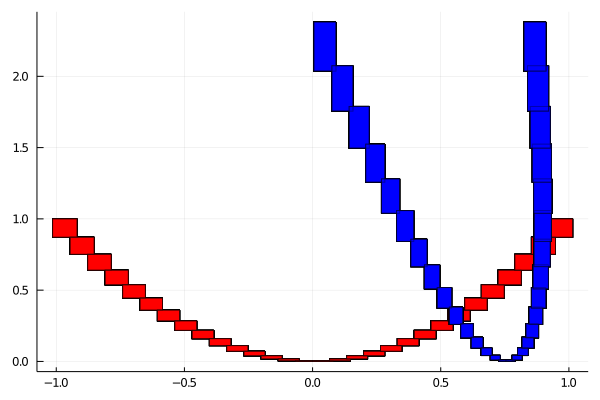

In [11]:
plot(UnionSetArray(overapproximate(sol[1], Hyperrectangle, 30).X.array), c=:red)

plot!(UnionSetArray(overapproximate(sol[end], Hyperrectangle, 30).X.array), c=:blue)

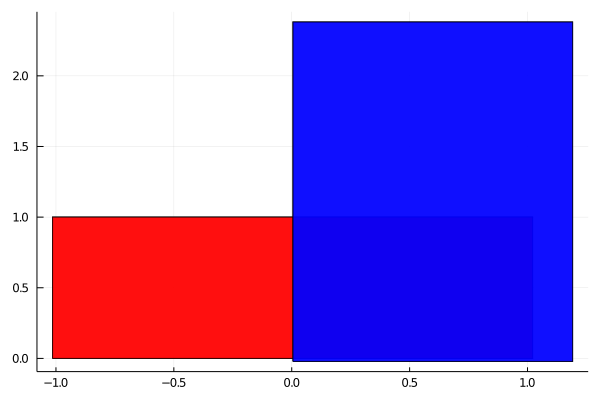

In [15]:
plot(UnionSetArray(_overapproximate(sol[1], Zonotope, 2).X.array), c=:red)

plot!(UnionSetArray(_overapproximate(sol[end], Zonotope, 2).X.array), c=:blue)

In [201]:
#plot(UnionSetArray(overapproximate(sol[1], Hyperrectangle, 30).X.array))
plot(UnionSetArray(_overapproximate(sol[end], Zonotope, 30).X.array))

LoadError: [91mMethodError: no method matching overapproximate(::TaylorModelN{2,Float64,Float64}, ::Type{Zonotope})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  overapproximate([91m::EmptySet[39m, ::Type{var"#s438"} where var"#s438"<:Zonotope) at /home/sguadalupe/.julia/dev/LazySets/src/Approximations/overapproximate.jl:136[39m
[91m[0m  overapproximate([91m::EmptySet[39m, ::Type{var"#s436"} where var"#s436"<:Zonotope, [91m::LazySets.Approximations.AbstractDirections[39m; algorithm, kwargs...) at /home/sguadalupe/.julia/dev/LazySets/src/Approximations/overapproximate.jl:1423[39m
[91m[0m  overapproximate([91m::EmptySet[39m, ::Type{var"#s435"} where var"#s435"<:Zonotope, [91m::Type{var"#s434"} where var"#s434"<:LazySets.Approximations.AbstractDirections[39m; algorithm, kwargs...) at /home/sguadalupe/.julia/dev/LazySets/src/Approximations/overapproximate.jl:1428[39m
[91m[0m  ...[39m

In [95]:
IA.IntervalBox(IA.Interval.(getproperty.(IB.v, :lo)))

[-0.349157, -0.349156] × [-2.84804, -2.84803]

In [129]:
IA.IntervalBox(IA.Interval.(RA.center(convert(Hyperrectangle, IB))))

[-0.0810681, -0.081068] × [-1.00397, -1.00396]